## Reconstrucción 3D con Structure from Motion

José Daniel Mejía

### Dependencias

In [1]:
#!pip install opencv-python numpy matplotlib scipy

In [ ]:
#!pip install open3d

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import struct
import os

### Preprocesamiento de imágenes

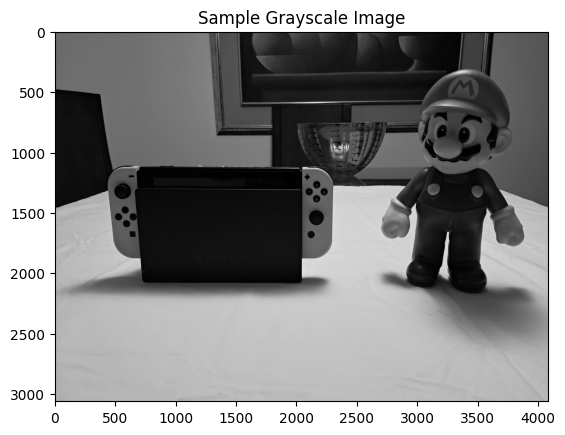

In [21]:
image_paths = glob.glob("../imagenes/imagenes_modelo/*.jpg") 
images = [cv2.imread(img_path) for img_path in sorted(image_paths)]

imS = cv2.resize(images[0], (800, 600))           
cv2.imshow("imagen", imS)                    
cv2.waitKey(0)       

gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

plt.imshow(gray_images[0], cmap="gray")
plt.title("Sample Grayscale Image")
plt.show()


### Detección y Correspondencia de Características

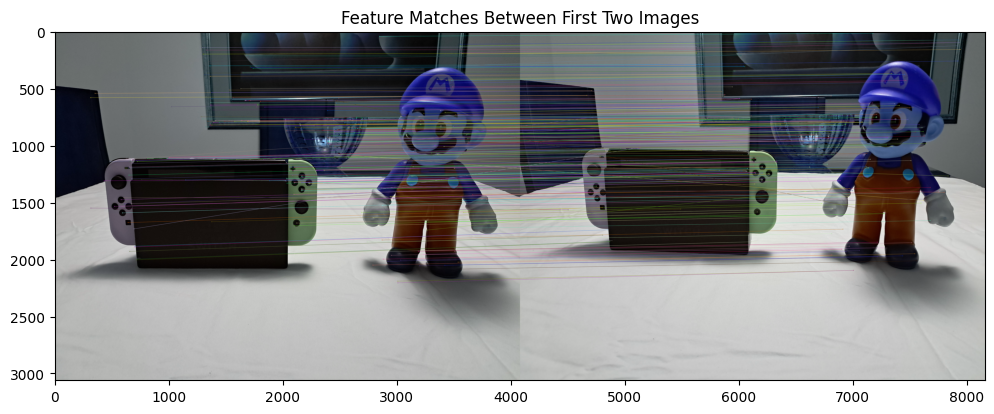

In [4]:
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_descriptors = [sift.detectAndCompute(img, None) for img in gray_images]

# FLANN-based matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match keypoints between consecutive images
matches = []
for i in range(len(images) - 1):
    kp1, des1 = keypoints_descriptors[i]
    kp2, des2 = keypoints_descriptors[i + 1]
    
    # Match descriptors
    raw_matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe’s ratio test
    good_matches = [m for m, n in raw_matches if m.distance < 0.7 * n.distance]
    matches.append(good_matches)

# Draw matches for visualization
img_matches = cv2.drawMatches(images[0], keypoints_descriptors[0][0], 
                              images[1], keypoints_descriptors[1][0], 
                              matches[0], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.title("Feature Matches")
plt.show()


###  Estimación de Matriz Esencial

In [5]:
CHESSBOARD_SIZE = (7, 7)
SQUARE_SIZE = 0.05

def calibrate_camera(images_folder):
    # Prepare object points
    objp = np.zeros((CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)
    objp *= SQUARE_SIZE

    objpoints = []
    imgpoints = [] 

    images = glob.glob(images_folder + '*.jpg')

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None)
        
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None
    )

    return camera_matrix, dist_coeffs

CALIBRATION_IMAGES_FOLDER = '../imagenes/Chessboard/'

K, dist_coeffs = calibrate_camera(CALIBRATION_IMAGES_FOLDER)

In [6]:
def get_matched_points(kp1, kp2, matches):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    return pts1, pts2

kp1, kp2 = keypoints_descriptors[0][0], keypoints_descriptors[1][0]
pts1, pts2 = get_matched_points(kp1, kp2, matches[0])

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

E = K.T @ F @ K
print("Matriz esencial:\n", E)


Essential Matrix:
 [[  -2.34134983  102.92748688   70.92451349]
 [ -88.92636134    2.46852946 -164.90293372]
 [ -65.02076743  156.34020405   -7.4968455 ]]


### Reconstrucción 3D

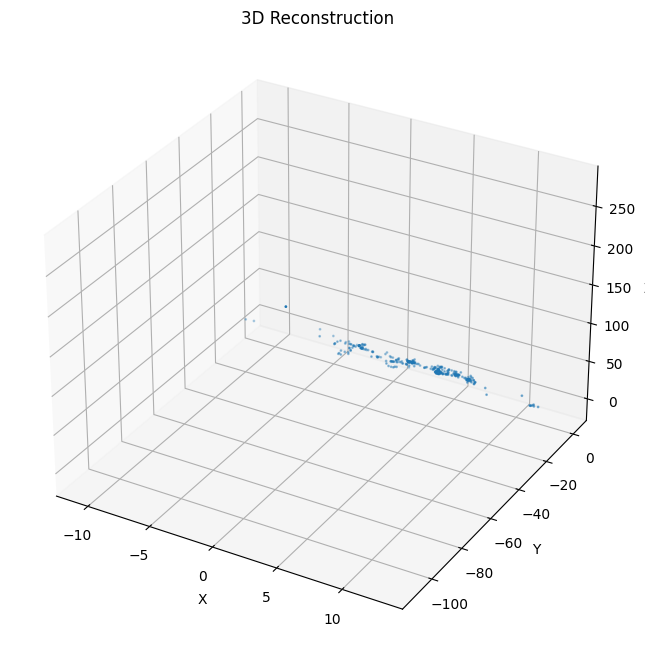

In [8]:
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = np.hstack((R_mat, t))

P1 = K @ P1
P2 = K @ P2

# Triangulación de puntos
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
points_3d = points_4d_hom[:3] / points_4d_hom[3]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[0], points_3d[1], points_3d[2], s=1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Recontrucción 3D")
plt.show()


### Recostrucción 3D con Colmap

In [22]:
import numpy as np
import open3d as o3d

def load_colmap_sparse_points(points3D_txt):
    points = []
    with open(points3D_txt, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue  # Skip comments
            data = line.strip().split()
            xyz = np.array([float(data[1]), float(data[2]), float(data[3])])  # Extract 3D coordinates
            points.append(xyz)
    return np.array(points)

points3D_txt = "./sparse/0/points3D.txt"
point_cloud = load_colmap_sparse_points(points3D_txt)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)

o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [23]:
import open3d as o3d

cloud = o3d.io.read_point_cloud(
    './dense/0/fused.ply'
)

print(cloud)

o3d.visualization.draw_geometries([cloud])

PointCloud with 305326 points.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
